<a href="https://colab.research.google.com/github/krislars/R-uncertainty/blob/master/MonteCarloModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
import numpy as np
import numpy.random as npRand
from matplotlib import pyplot as plt

In [0]:
%matplotlib inline

Data file format is intrinsic stellar H-K, sigma H-K, J-H, sigma J-H ... (Sam will check this and add a reference)

In [0]:
starData = np.loadtxt("https://raw.githubusercontent.com/krislars/R-uncertainty/master/Astro%20Lab%20Star%20Data.txt")
starData = np.transpose(starData)
B, dB = starData[0], starData[1]
D, dD = starData[2], starData[3]

This next line is propagation of error in an arithmetic function.

In [0]:
#calculating theoretical dR
dR = 1.6 *(dB**2 + .02**2 + 1.6 *(dD**2 + .02**2))**0.5

This function takes a vector of values and a vector of associated uncertainties and returns an array of n = numVals samples selected randomly from a normal  probability distribution.

In [0]:
#choosing random data sets for each star type
def getData(mean, sigma, numVals):
    data = np.array(
        [npRand.normal(m, s, numVals) for m, s in zip(mean, sigma)]
    )
    return data

In [0]:
B_vals = getData(B, dB, 1000)
D_vals = getData(D, dD, 1000)

$$
R = \frac{A-B}{C-D}
$$

We will choose values such that the numerator is 1.  So, $A=1+B$.  We also choose the value of R to be 1.6, so $C-D=1/1.6$.  Therefore, $C = 1/1.6+D$.



In [0]:
A = 1 + B
C = 1/1.6 + D
dA = np.linspace(0.02, 0.02, 50)
A_vals = getData(A, dA, 1000)
C_vals = getData(C, dA, 1000)

In [0]:
#calculating the "Monte Carlo" values for R and dR
R_vals = (A_vals - B_vals) / (C_vals - D_vals)


Now, we can test the distributions of R.

In [0]:
R_mc = np.mean(R_vals, axis=1)
dR_mc = np.std(R_vals, axis=1)

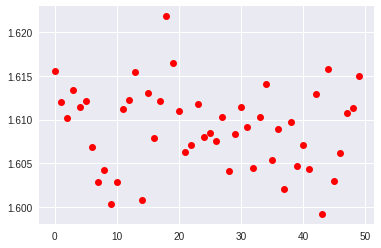

In [18]:
plt.plot(R_mc,'ro')

Ideas going forward:
* Calculate the uncertainty in the mean.
* Try a weighted mean
* Try making all the errors the same
* Try making the errors very small
* Test that you are resetting the random number *seed* 



In [0]:
#Next I need to test "Goodness of fit"

